In [1]:
!pip install xarray

In [1]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np  # Numerical operations
import xarray as xr  # Load and manipulate NetCDF files
import tensorflow as tf  # Building and training machine learning models
from tensorflow.keras.models import Sequential  # Model building
from tensorflow.keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Dense, Flatten, Reshape, ConvLSTM2D, Dropout, MaxPooling3D, BatchNormalization  # Layers for CNN and LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler  # For data normalization
from sklearn.metrics import mean_absolute_error  # For model evaluation
import matplotlib.pyplot as plt  # For visualizations

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load NetCDF File
dataset = xr.open_dataset('./drive/My Drive/Colab Notebooks/Extreme Weather in Tanzania Predictions/data/output.nc')

In [4]:
dataset

<xarray.Dataset> Size: 487MB
Dimensions:      (valid_time: 2047, latitude: 45, longitude: 49)
Coordinates:
  * valid_time   (valid_time) datetime64[ns] 16kB 2019-01-01 ... 2024-08-08
  * longitude    (longitude) float64 392B 29.0 29.25 29.5 ... 40.5 40.75 41.0
  * latitude     (latitude) float64 360B -12.0 -11.75 -11.5 ... -1.5 -1.25 -1.0
Data variables: (12/27)
    z_min        (valid_time, latitude, longitude) float32 18MB ...
    z_max        (valid_time, latitude, longitude) float32 18MB ...
    z_mean       (valid_time, latitude, longitude) float32 18MB ...
    z_median     (valid_time, latitude, longitude) float32 18MB ...
    r_min        (valid_time, latitude, longitude) float32 18MB ...
    r_max        (valid_time, latitude, longitude) float32 18MB ...
    ...           ...
    v_max        (valid_time, latitude, longitude) float32 18MB ...
    v_mean       (valid_time, latitude, longitude) float32 18MB ...
    v_median     (valid_time, latitude, longitude) float32 18MB ...
    day_of_year  (valid_time, latitude, longitude) int32 18MB ...
    month        (valid_time, latitude, longitude) int32 18MB ...
    day          (valid_time, latitude, longitude) int32 18MB ...

In [5]:
# To get dimensions (e.g., time, lat, lon)
print(dataset.dims)

# To get the coordinates (the indexes)
print(dataset.coords)

# To get the variables (the features)
print(dataset.data_vars)

# List of all available variable names
print("All variable names: ", list(dataset.data_vars.keys()))

FrozenMappingWarningOnValuesAccess({'valid_time': 2047, 'latitude': 45, 'longitude': 49})
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 16kB 2019-01-01 ... 2024-08-08
  * longitude   (longitude) float64 392B 29.0 29.25 29.5 ... 40.5 40.75 41.0
  * latitude    (latitude) float64 360B -12.0 -11.75 -11.5 ... -1.5 -1.25 -1.0
Data variables:
    z_min        (valid_time, latitude, longitude) float32 18MB ...
    z_max        (valid_time, latitude, longitude) float32 18MB ...
    z_mean       (valid_time, latitude, longitude) float32 18MB ...
    z_median     (valid_time, latitude, longitude) float32 18MB ...
    r_min        (valid_time, latitude, longitude) float32 18MB ...
    r_max        (valid_time, latitude, longitude) float32 18MB ...
    r_mean       (valid_time, latitude, longitude) float32 18MB ...
    r_median     (valid_time, latitude, longitude) float32 18MB ...
    q_min        (valid_time, latitude, longitude) float32 18MB ...
    q_max        (valid_time, latitude

In [6]:
# Initialize MinMaxScaler to scale the data between 0 and 1
scaler = MinMaxScaler()

In [7]:
# Calculate wind speed from u and v components
dataset['wind_speed_mean'] = np.sqrt(dataset['u_mean']**2 + dataset['v_mean']**2)

In [8]:
# Select features (inputs to the model) and targets (outputs we want to predict)
features = ['r_mean', 'q_mean', 'z_mean', 't_mean']
X = dataset[features]  # Input features

y_wind = dataset['wind_speed_mean']  # Wind speed target

In [9]:
# Reshape data
X = X.to_array().transpose('valid_time', 'latitude', 'longitude', 'variable').values

# Flatten, normalize, and reshape
X_orig_shape = X.shape
X = X.reshape(-1, len(features))
X = scaler.fit_transform(X)
X = X.reshape(X_orig_shape)

# Normalize the target
y_wind = scaler.fit_transform(y_wind.values.reshape(-1, 1)).reshape(y_wind.shape)

In [10]:
print(X.shape)

(2047, 45, 49, 4)


In [11]:
y_wind.shape

(2047, 45, 49)

In [12]:
# Define the split size (80% train, 20% test)
train_size = int(0.8 * X.shape[0])

# Split the data into training and testing sets (ensure sequential order)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y_wind[:train_size], y_wind[train_size:]

# Parameters
time_steps = 7

# Create TimeSeriesDataset for training data
train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_train, y_train, sequence_length=time_steps, batch_size=X_train.shape[0]
)

# Create TimeSeriesDataset for testing data
test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_test, y_test, sequence_length=time_steps, batch_size=X_test.shape[0]
)

In [13]:
for train_batch_X, train_batch_y in train_dataset:
    print(f'Train Shape: {train_batch_X.shape}, {train_batch_y.shape}')

for test_batch_X, test_batch_y in test_dataset:
    print(f'Test shape: {test_batch_X.shape}, {test_batch_y.shape}')

Train Shape: (1631, 7, 45, 49, 4), (1631, 45, 49)
Test shape: (404, 7, 45, 49, 4), (404, 45, 49)


In [14]:
def build_model(time_steps, lat, lon, features):
    model = Sequential()
    # model.add(TimeDistributed(Conv2D(128, (1, 1), activation='relu', padding='same'),
    #                           input_shape=(time_steps, lat, lon, features)))
    # model.add(TimeDistributed(BatchNormalization()))
    # model.add(TimeDistributed(MaxPooling2D((1, 1))))
    # model.add(TimeDistributed(Flatten()))
    # model.add(Dropout(0.2))
    # model.add(LSTM(64, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dense(lat * lon))
    # model.add(Reshape((lat, lon)))
    model.add(ConvLSTM2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(time_steps, lat, lon, features), padding='same', return_sequences=True))
    model.add(MaxPooling3D((1, 2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(lat * lon))
    model.add(Reshape((lat, lon)))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.summary()
    return model


# Initialize the model
model = build_model(time_steps, X_train.shape[1], X_train.shape[2], X_train.shape[3])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 7, 45, 49, 32)       │          18,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 7, 22, 24, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 22, 24, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 118272)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2205)                │     260,791,965 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 45, 49)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 260,810,525 (994.91 MB)

 Trainable params: 260,810,525 (994.91 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor (validation loss in this case)
    patience=5,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1              # Display progress messages
)

In [16]:
X_train_dataset, y_train_dataset = next(iter(train_dataset))
X_test_dataset, y_test_dataset = next(iter(test_dataset))

In [17]:
# Train the wind speed prediction model
history_wind = model.fit(
    X_train_dataset,
    y_train_dataset,
    validation_data=(X_test_dataset, y_test_dataset),
    epochs=30,
    batch_size=128,
    callbacks=[early_stopping]
)

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - loss: 0.4643 - mae: 0.5187 - val_loss: 0.0510 - val_mae: 0.1947
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 437ms/step - loss: 0.0339 - mae: 0.1583 - val_loss: 0.0132 - val_mae: 0.0912
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 490ms/step - loss: 0.0103 - mae: 0.0800 - val_loss: 0.0083 - val_mae: 0.0699
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step - loss: 0.0065 - mae: 0.0600 - val_loss: 0.0049 - val_mae: 0.0495
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 470ms/step - loss: 0.0047 - mae: 0.0483 - val_loss: 0.0042 - val_mae: 0.0444
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 458ms/step - loss: 0.0037 - mae: 0.0428 - val_loss: 0.0041 - val_mae: 0.0434
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 449ms/step - loss: 0.0034 - mae: 0.0406 - val_loss: 0.0035 - val_mae: 0.0401
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 431ms/step - loss: 0.0030 - mae: 0.0378 - val_loss: 0.0030 - val_mae: 0.0375
Epoch 9/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 329ms/step -

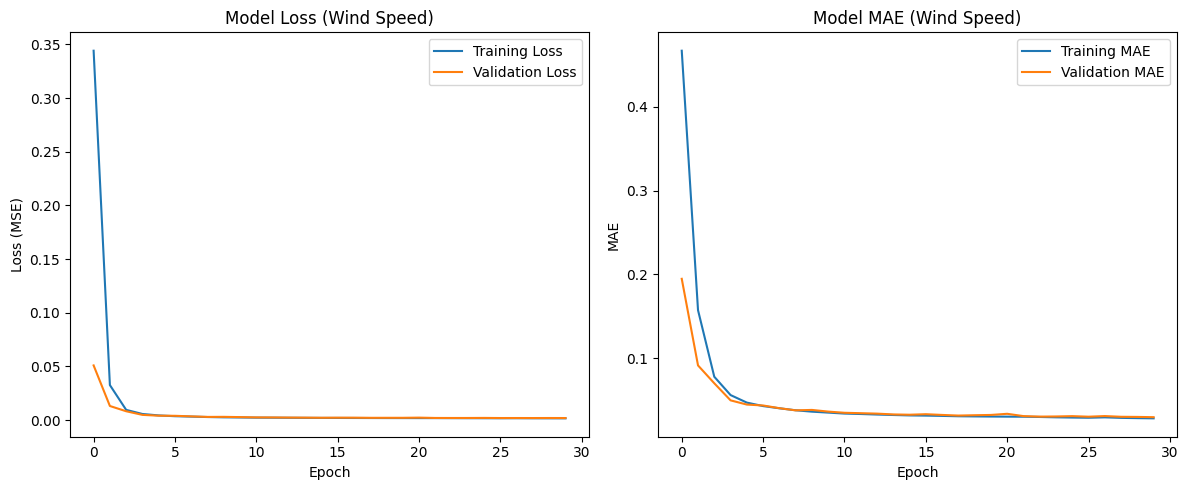

In [18]:
# Plot training & validation loss and MAE for wind speed model
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history_wind.history['loss'], label='Training Loss')
plt.plot(history_wind.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Wind Speed)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

# Plot training and validation MAE
plt.subplot(1, 2, 2)
plt.plot(history_wind.history['mae'], label='Training MAE')
plt.plot(history_wind.history['val_mae'], label='Validation MAE')
plt.title('Model MAE (Wind Speed)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
# Make predictions on the test data
y_pred_wind = model.predict(X_test_dataset)

# Reshape data for inverse normalization
y_test_wind_flat = tf.reshape(y_test_dataset, [-1, 1])
y_pred_wind_flat = tf.reshape(y_pred_wind, [-1, 1])

# Convert back to original scale
y_test_wind_inv = scaler.inverse_transform(y_test_wind_flat)
y_pred_wind_inv = scaler.inverse_transform(y_pred_wind_flat)

# Calculate Mean Absolute Error
mae_wind = mean_absolute_error(y_true=y_test_wind_inv, y_pred=y_pred_wind_inv)
print(f'Wind Speed MAE: {mae_wind}')


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
Wind Speed MAE: 0.5257980018666637


In [20]:
from sklearn.metrics import r2_score

In [21]:
r2_wind = r2_score(y_test_wind_inv, y_pred_wind_inv)
print(f'Wind Speed R²: {r2_wind}')

Wind Speed R²: 0.8555260813416448


In [23]:
def estimate_model_size(model):
    # Get the total number of parameters in the model
    total_params = model.count_params()

    # Each parameter is typically 4 bytes (32 bits) in size
    param_size_bytes = 4  # 32 bits = 4 bytes

    # Estimate the total model size in bytes
    total_size_bytes = total_params * param_size_bytes

    # Convert bytes to megabytes (1 MB = 1024 * 1024 bytes)
    total_size_mb = total_size_bytes / (1024 * 1024)

    print(f"Estimated model size: {total_size_mb:.2f} MB")

# Example usage
estimate_model_size(model)

Estimated model size: 994.91 MB


In [25]:
model.save_weights('wind_speed_prediction_model.weights.h5')

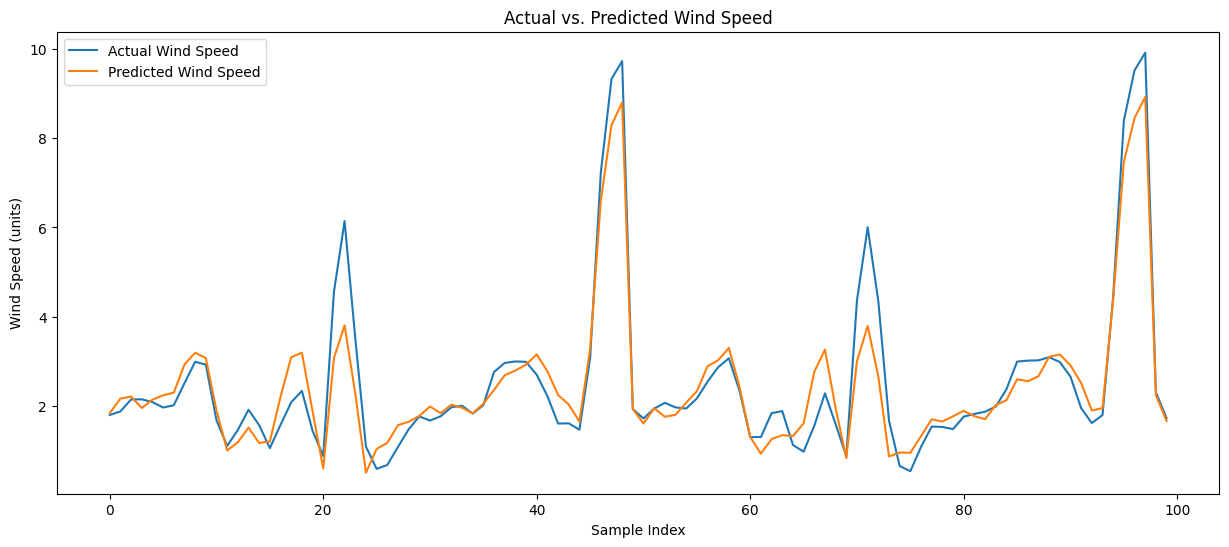

In [26]:
# Select a subset for plotting
num_samples = 100  # Adjust as needed
plt.figure(figsize=(15, 6))

# Plot actual wind speed values
plt.plot(y_test_wind_inv[:num_samples], label='Actual Wind Speed')

# Plot predicted wind speed values
plt.plot(y_pred_wind_inv[:num_samples], label='Predicted Wind Speed')

plt.xlabel('Sample Index')
plt.ylabel('Wind Speed (units)')  # Replace with the actual units if applicable, e.g., m/s
plt.title('Actual vs. Predicted Wind Speed')
plt.legend()
plt.show()

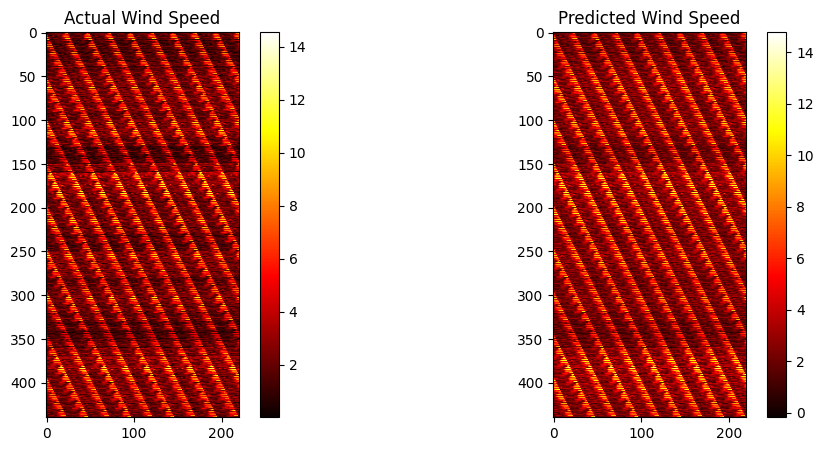

In [27]:
# Select a sample to visualize
sample_index = 0

# Reshape to 2D assuming lat and lon are defined previously
lat = 440 # Example value
lon = 220 # Example value

# Actual and predicted wind speed
actual_wind = y_test_wind_inv[sample_index * lat * lon : (sample_index + 1) * lat * lon].reshape(lat, lon)
predicted_wind = y_pred_wind_inv[sample_index * lat * lon : (sample_index + 1) * lat * lon].reshape(lat, lon)

# Plot the actual vs predicted wind speed
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(actual_wind, cmap='hot')
plt.title('Actual Wind Speed')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(predicted_wind, cmap='hot')
plt.title('Predicted Wind Speed')
plt.colorbar()

plt.show()